In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import scipy.stats as stats

import plotly
import kaleido
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.tools import add_constant

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from datetime import date
import itertools

# 0. Load data

In [3]:
Y_COL_NAME = "total_deposits_from_non-bank_customer"

In [4]:
## Load original dataframe

today = str(date.today()).replace("-", "")

original_df = pd.read_csv(f"analyze-dataset/merged_data_{today}.csv")
df = original_df.copy()

###### drop some useless columns
df = df.drop(
    columns=[
        "domestic_debt",  # remove, use total natinal debt
        "external_debt",  # remove, use total natinal debt
        "Compound SORA - 1 month",  # remove since lack of data
        "Compound SORA - 3 month",  # remove since lack of data
        "Compound SORA - 6 month",  # remove since lack of data
        "average_MNE_per_employee_overall_economy",  # remove since lack of data
        "Resident Unemployment Rate",  # remove, use total unemployment rate
        "Citizen Unemployment Rate",  # remove, use total unemployment rate
        "GDP_year_on_year_growth_rate_current_price",  # remove, use in-chain data
        "household_net_worth",  # remove, consider as irrelevant
        "gross_fixed_capital_formation_current_price",  # remove, use in chain
    ]
)

df = df.rename(
    columns={
        "lag3q_Age Dependency Ratio: Residents Aged Under 15 Years And 65 Years Per Hundred Residents Aged 15-64 Years (Number)": "lag3q_Age Dependency Ratio (15-64 Years)"
    }
)

# add quarter information
# TODO: one hot encoding for Quarter
df["Year"] = df["Data Series"].apply(lambda s: int(s.split(" ")[0]))
df["Qrt"] = df["Data Series"].apply(lambda s: int(s.split(" ")[1][0]))
display(df.head())

for c in df.columns:
    print(c)
print(df.shape)

,Data Series,total_deposits_from_non-bank_customer,Prime Lending Rate,CPI_all_items_base_2019,DSPI_all_items_base_2018,IPI_all_items_base_2018,EPI_all_items_base_2018,lag3q_Total Population (Number),lag3q_Total Population Growth (Per Cent),lag3q_Age Dependency Ratio (15-64 Years),...,housing_and_development_board_resale_price_index,GDP_year_on_year_growth_rate_in_chain_2015,GDP_in_chain_2015,Personal Disposable Income (Million Dollars),Personal Saving (Million Dollars),Personal Saving Rate (Per Cent),Total Unemployment Rate,Unit Labour Cost Of Overall Economy,Year,Qrt
0,1991 1Q,194776.5,7.436667,64.281333,107.336667,118.772667,179.648333,3047132.0,2.3,40.8,...,24.9,6.4,25457.6,10497.8,2179.8,20.8,NaN,79.0,1991,1
1,1991 2Q,198990.8,7.523333,64.772667,102.607667,115.454667,170.185667,3047132.0,2.3,40.8,...,25.5,6.5,25819.2,10067.8,1852.3,18.4,NaN,80.9,1991,2
2,1991 3Q,206741.1,7.890000,65.124000,101.448333,114.300333,167.685667,3047132.0,2.3,40.8,...,25.2,7.3,26244.2,10521.4,2040.7,19.4,NaN,81.6,1991,3
3,1991 4Q,211731.7,7.483333,65.425333,101.229667,113.867667,165.380667,3135083.0,2.9,41.0,...,25.1,6.5,26456.1,12412.4,3463.3,27.9,NaN,82.6,1991,4
4,1992 1Q,218934.1,6.303333,65.710000,97.909000,110.981333,159.644000,3135083.0,2.9,41.0,...,25.8,5.7,26919.1,11200.1,2228.7,19.9,1.5,83.5,1992,1


Data Series
total_deposits_from_non-bank_customer
Prime Lending Rate
CPI_all_items_base_2019
DSPI_all_items_base_2018
IPI_all_items_base_2018
EPI_all_items_base_2018
lag3q_Total Population (Number)
lag3q_Total Population Growth (Per Cent)
lag3q_Age Dependency Ratio (15-64 Years)
lag3q_per_capita_GDP_in_chain_2015
total_change_in_employment_quarterly
composite_leading_index_base_2015
total_government_debt
gross_fixed_capital_formation_in_chain_2015
housing_and_development_board_resale_price_index
GDP_year_on_year_growth_rate_in_chain_2015
GDP_in_chain_2015
Personal Disposable Income (Million Dollars)
Personal Saving (Million Dollars)
Personal Saving Rate (Per Cent)
Total Unemployment Rate
Unit Labour Cost Of Overall Economy
Year
Qrt
(122, 25)


# 1. Linear Model

## 1.1 Simple Linear Model

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [6]:
class MyLR:
    def __init__(self, train_X, train_y):

        self.model = None
        self.fitted_model = None
        self.train_result_tables = None

        self.train_X = train_X
        self.train_y = train_y
        self.N, self.D = train_X.shape

        # print(self.N, self.D)

        # train linear regression model
        self.train()

    def train(self):

        # !!! Don't forget to add bias column
        self.model = sm.OLS(self.train_y, add_constant(self.train_X))
        self.fitted_model = self.model.fit()
        self.train_result_tables = self.fitted_model.summary2().tables

    def predict(self, X):
        X = sm.add_constant(X)
        return self.fitted_model.predict(X)

    def get_train_summary(self):
        summary = self.fitted_model.summary2()
        return summary

    def get_train_eval(self, selected_metrics: list = None):
        res_df = self.train_result_tables[0]

        part1 = res_df[[0, 1]]
        part2 = res_df[[2, 3]]
        part2.columns = part1.columns
        res_df = pd.concat([part1, part2])

        res_df = res_df.T
        res_df.columns = res_df.iloc[0].apply(lambda s: s.strip().replace(":", ""))
        res_df = res_df.iloc[1:]

        compulsory_cols = list(res_df.columns[:6])

        if selected_metrics:
            res_df = res_df[compulsory_cols + selected_metrics]

        return res_df

    def get_res_tables(self):
        return self.res_tables

    def rmse(self, real_y, predict_y):

        rmse = mean_squared_error(real_y, predict_y, squared=False)
        return rmse

    def R2(self, real_y, predict_y):
        R2 = r2_score(real_y, predict_y)
        return R2

    def adj_R2(self, real_y, predict_y):
        R2 = self.R2(real_y, predict_y)
        adj_r2_score = 1 - (1 - R2) * (self.N - 1) / (self.N - self.D - 1)
        return adj_r2_score

    def MPE(self, real_y, predict_y):
        """
        Mean Percentage Error
        """
        #### test code
        # print(predict_y - real_y)
        # print((predict_y - real_y) / real_y)

        mpe = np.mean((predict_y - real_y) / real_y)
        return mpe

    def MAPE(self, real_y, predict_y):
        """
        return float?
        
        """
        mape = mean_absolute_percentage_error(real_y, predict_y)
        return mape

In [7]:
SLR_df = df.dropna().copy().reset_index(drop=True)

print(SLR_df.shape)

SLR_df.head()

(118, 25)


,Data Series,total_deposits_from_non-bank_customer,Prime Lending Rate,CPI_all_items_base_2019,DSPI_all_items_base_2018,IPI_all_items_base_2018,EPI_all_items_base_2018,lag3q_Total Population (Number),lag3q_Total Population Growth (Per Cent),lag3q_Age Dependency Ratio (15-64 Years),...,housing_and_development_board_resale_price_index,GDP_year_on_year_growth_rate_in_chain_2015,GDP_in_chain_2015,Personal Disposable Income (Million Dollars),Personal Saving (Million Dollars),Personal Saving Rate (Per Cent),Total Unemployment Rate,Unit Labour Cost Of Overall Economy,Year,Qrt
0,1992 1Q,218934.1,6.303333,65.710000,97.909,110.981333,159.644000,3135083.0,2.9,41.0,...,25.8,5.7,26919.1,11200.1,2228.7,19.9,1.5,83.5,1992,1
1,1992 2Q,226763.1,6.163333,66.245667,99.444,112.640667,159.595667,3135083.0,2.9,41.0,...,27.4,5.4,27242.4,10509.8,1553.0,14.8,2.4,84.1,1992,2
2,1992 3Q,232916.5,5.793333,66.586333,99.163,112.171667,159.448667,3135083.0,2.9,41.0,...,28.0,6.7,27973.8,10961.8,1770.5,16.2,1.6,83.9,1992,3
3,1992 4Q,234922.8,5.550000,66.886667,98.097,110.981667,159.791667,3230698.0,3.0,41.0,...,28.6,8.7,28725.1,13000.9,3325.3,25.6,1.7,83.7,1992,4
4,1993 1Q,233819.7,5.493333,67.344000,96.250,109.576000,158.419000,3230698.0,3.0,41.0,...,30.2,9.0,29362.8,11924.9,1536.7,12.9,1.2,83.8,1993,1


- For each single variable, build a simple linear regression model (excluding nan-value rows), collect corresponding metrics.

In [8]:
def get_SLR_analysis_results(
    X, y, selected_criteria=["Adj. R-squared", "AIC", "BIC", "Prob (F-statistic)",],
):

    df_to_concat = []

    original_y = y.copy()

    for i, col_name in enumerate(X.columns):

        # print("==================" + col_name + "==================")
        single_X = X[[col_name]].loc[X[col_name].notnull()]
        single_X = np.array(single_X)

        current_y = original_y.loc[X[col_name].notnull()]

        # print(single_X.shape)
        # print(current_y.shape)

        mySLR = MyLR(train_X=single_X, train_y=current_y)

        eval_df = mySLR.get_train_eval(selected_criteria)
        # display(eval_t)
        # model_t = mySLR.get_model()

        # create alias for independent variables
        eval_df["x_name"] = col_name
        eval_df["x_alias"] = f"V_{i+1}"

        df_to_concat.append(eval_df)

        # display(current_res_df)

    res_df = pd.concat(df_to_concat).reset_index(drop=True)

    res_df[selected_criteria] = res_df[selected_criteria].astype("float64")

    # print("!!!!" + str(res_df.shape))

    return res_df


X = SLR_df.iloc[:, 2:].copy()

y = SLR_df[Y_COL_NAME].copy()

SLR_analysis_res_df = get_SLR_analysis_results(X, y)

print("================ SLR result ===================")
print(SLR_analysis_res_df.shape)

SLR_analysis_res_df

================ SLR result ===================
(23, 12)


,Model,Dependent Variable,Date,No. Observations,Df Model,Df Residuals,Adj. R-squared,AIC,BIC,Prob (F-statistic),x_name,x_alias
0,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.277,3451.8477,3457.3891,5.590000e-10,Prime Lending Rate,V_1
1,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.962,3104.4795,3110.0208,2.180000e-84,CPI_all_items_base_2019,V_2
2,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.048,3484.3135,3489.8548,9.780000e-03,DSPI_all_items_base_2018,V_3
3,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.149,3471.0810,3476.6223,9.410000e-06,IPI_all_items_base_2018,V_4
4,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.808,3295.3434,3300.8848,1.320000e-43,EPI_all_items_base_2018,V_5
5,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.950,3136.2543,3141.7957,1.330000e-77,lag3q_Total Population (Number),V_6
6,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.228,3459.6066,3465.1479,2.770000e-08,lag3q_Total Population Growth (Per Cent),V_7
7,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.267,3453.4308,3458.9721,1.240000e-09,lag3q_Age Dependency Ratio (15-64 Years),V_8
8,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.953,3129.5083,3135.0497,4.830000e-79,lag3q_per_capita_GDP_in_chain_2015,V_9
9,OLS,total_deposits_from_non-bank_customer,2022-09-09 11:10,118,1,116,0.024,3487.2037,3492.7450,4.990000e-02,total_change_in_employment_quarterly,V_10


### Plot Bar chart of R-squared for simple linear regression  

The bar chart has shown that **Vxxx** has lowest R-squared metric for simple linear regression.   
Correspondingly, **Vxx** got relatively higher p-values.  

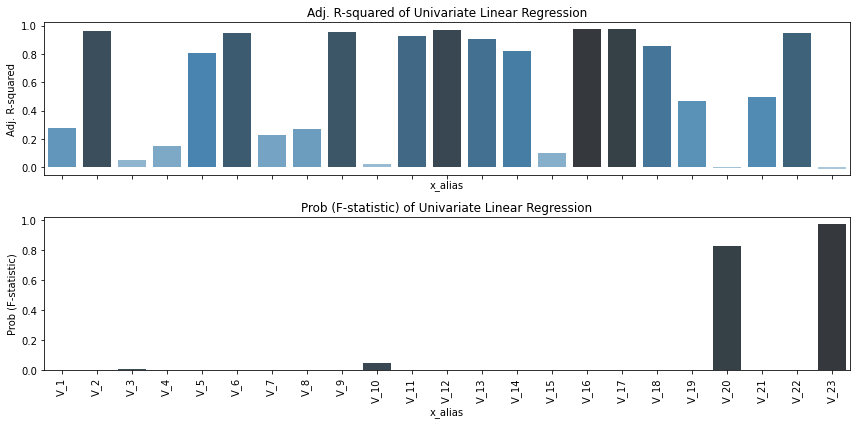

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1, ax2 = axs.flat
plt.xticks(rotation=90)


#### Plot adjusted R-squared ####

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = (
    SLR_analysis_res_df["Adj. R-squared"].argsort().argsort()
)  # http://stackoverflow.com/a/6266510/1628638

plot1 = sns.barplot(
    ax=ax1,
    x="x_alias",
    y="Adj. R-squared",
    data=SLR_analysis_res_df,
    palette=np.array(pal)[rank],
)

ax1.set_title("Adj. R-squared of Univariate Linear Regression")

#### Plot p-values ####

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = (
    SLR_analysis_res_df["Prob (F-statistic)"].argsort().argsort()
)  # http://stackoverflow.com/a/6266510/1628638
# sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])

plot2 = sns.barplot(
    ax=ax2,
    x="x_alias",
    y="Prob (F-statistic)",
    data=SLR_analysis_res_df,
    palette=np.array(pal)[rank],
)

ax2.set_title("Prob (F-statistic) of Univariate Linear Regression")

plt.tight_layout()
plt.show()

## 1.2 Multiple Linear Model  

- [Cross Validation in Machine Learning using StatsModels and Sklearn with Logistic Regression Example](https://medium.com/analytics-vidhya/cross-validation-in-machine-learning-using-python-4d0f335bec83)  
- [How to Selecting Predictors](https://otexts.com/fpp2/selecting-predictors.html)  
- [statsmodel wrapper for sklearn cross-validation](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible)

In [10]:
from sklearn.model_selection import KFold

MLR_df = SLR_df.copy()

In [11]:
def select_k(list_like, k: int, return_index=False):

    if return_index:
        ls_index = range(len(list_like))
        res = itertools.combinations(ls_index, k)
    else:
        res = itertools.combinations(list_like, k)
    return res


######## Dataset K-fold split
def get_k_fold_index_list(df, n_splits=5, random_state=None, shuffle=False):

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(df)

    k_fold_index_ls = []

    for train_index, test_index in kf.split(df):
        # print("TRAIN:", train_index, "TEST:", test_index)
        train_test_pair = {"train_index": train_index, "test_index": test_index}
        k_fold_index_ls.append(train_test_pair)

    return k_fold_index_ls


### test code

# aa_ls = [1, 2, "a", "b"]
# list(select_k(aa_ls, 2))

In [12]:
def get_cv_eval(df, y_name, x_names):
    # get k folds
    k_folds = get_k_fold_index_list(df, random_state=1, shuffle=True)

    selected_metrics = [
        "Adj. R-squared",
        "AIC",
        "BIC",
        "Prob (F-statistic)",
    ]

    res_df_ls = []

    for i, train_test_idx in enumerate(k_folds):

        ### test code ###
        train_df = df.iloc[train_test_idx["train_index"]]
        test_df = df.iloc[train_test_idx["test_index"]]

        # train data
        train_X, train_y = train_df[x_names], train_df[y_name]

        # test data
        test_X, test_y = test_df[x_names], test_df[y_name]

        # train model
        my_LR = MyLR(train_X, train_y)
        # print(my_LR.get_train_summary())

        # predict train X
        train_predict_y = my_LR.predict(train_X)

        train_rmse = my_LR.rmse(train_y, train_predict_y)
        train_R2 = my_LR.R2(train_y, train_predict_y)
        train_adjR2 = my_LR.adj_R2(train_y, train_predict_y)
        train_mpe = my_LR.MPE(train_y, train_predict_y)
        train_mape = my_LR.MAPE(train_y, train_predict_y)

        # predict new X
        test_predict_y = my_LR.predict(test_X)

        test_rmse = my_LR.rmse(test_y, test_predict_y)
        test_R2 = my_LR.R2(test_y, test_predict_y)  # predict-R2
        test_mpe = my_LR.MPE(test_y, test_predict_y)
        test_mape = my_LR.MAPE(test_y, test_predict_y)

        # get evaluation metrics for model
        res_df = my_LR.get_train_eval(selected_metrics)

        ## RMSE
        res_df["train_rmse"] = train_rmse
        res_df["test_rmse"] = test_rmse
        ## R2
        res_df["train_adjR2"] = train_adjR2
        res_df["train_R2"] = train_R2
        res_df["test_R2"] = test_R2
        ## MPE
        res_df["train_mpe"] = train_mpe
        res_df["test_mpe"] = test_mpe
        ## MPE
        res_df["train_mape"] = train_mape
        res_df["test_mape"] = test_mape

        res_df_ls.append(res_df)

    cv_res_df = pd.concat(res_df_ls)
    cv_res_df[selected_metrics] = cv_res_df[selected_metrics].astype("float64")
    cv_res_df.columns = ["avg_" + c for c in list(cv_res_df.columns)]
    cv_res_df = cv_res_df.groupby("avg_Model").mean().reset_index()

    return cv_res_df

### 1.2.1 Multiple Linear Regression: all variables, get feature importance

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [74]:


min_max_scaler = preprocessing.MinMaxScaler()
normalized_MLR_df = min_max_scaler.fit_transform(MLR_df.iloc[:, 1:])

X = normalized_MLR_df[:, 1:]
y = normalized_MLR_df[:, 0]

sk_LR_model = LinearRegression()
# fit the model
sk_LR_model.fit(X, y)
# get importance
importance = sk_LR_model.coef_

importance

array([-0.03196386,  0.25785718, -0.03151849, -0.02538198,  0.07522039,
        0.19938195,  0.01027231, -0.08161491, -0.00447435,  0.04044142,
        0.16046005,  0.71497997,  0.04644863, -0.06649328, -0.03549243,
        0.1225459 , -0.46411202,  0.33801926, -0.05823   ,  0.01048509,
        0.03743259, -0.13690471, -0.00579047])

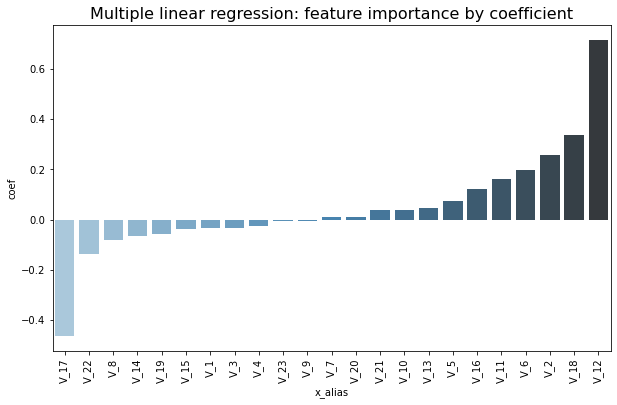

In [109]:
x_labels = ["V_" + str(i + 1) for i in range(len(importance))]
x = range(len(importance))

temp_df = pd.DataFrame([x_labels, importance]).T
temp_df.columns = ["x_alias", "coef"]


plt.figure(figsize=(10, 6))
plt.title("Multiple linear regression: feature importance by coefficient", fontsize=16)

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = np.abs(importance).argsort().argsort()
plt.xticks(rotation=90)

plot2 = sns.barplot(
    x="x_alias",
    y="coef",
    data=temp_df,
    # palette=np.array(pal)[rank],
    palette=pal,
    order=temp_df.sort_values("coef")["x_alias"],
)

### 1.2.2 Stepwise Regression: Backward elimination

In [13]:
from collections import defaultdict
import ast

In [21]:
y_name = Y_COL_NAME
current_x_columns = list(MLR_df.columns[2:])
k = len(current_x_columns)
criteria_metric = "avg_test_mape"


best_k_df_ls = []

while k > 0:

    print(
        f"============================ Feature Subset Size: {k-1} ================================="
    )
    current_x_combination = select_k(current_x_columns, k - 1)
    # print(list(current_x_combination)[0])

    ### get evaluation metrics for all combination of k subset
    temp_eval_ls = []
    for current_x in current_x_combination:

        cv_eval_df = get_cv_eval(MLR_df, y_name, list(current_x))

        cv_eval_df["columns"] = str(list(current_x))
        cv_eval_df["subset_size"] = k - 1

        # display(cv_eval_df)

        temp_eval_ls.append(cv_eval_df)

    print(f"number of candidates: {len(temp_eval_ls)}")
    temp_eval_df = pd.concat(temp_eval_ls)

    # display(temp_eval_df)

    ### get the one with maximum metric value
    best_k_df = temp_eval_df[
        temp_eval_df[criteria_metric] == temp_eval_df[criteria_metric].max()
    ]
    best_k_df_ls.append(best_k_df)

    ## next round select from best k
    best_k_columns = best_k_df["columns"].values[0]

    current_x_columns = ast.literal_eval(best_k_columns)

    k = k - 1


best_k_summary = pd.concat(best_k_df_ls).reset_index(drop=True)

============================ Feature Subset Size: 22 =================================
number of candidates: 23
============================ Feature Subset Size: 21 =================================
number of candidates: 22
============================ Feature Subset Size: 20 =================================
number of candidates: 21
============================ Feature Subset Size: 19 =================================
number of candidates: 20
============================ Feature Subset Size: 18 =================================
number of candidates: 19
============================ Feature Subset Size: 17 =================================
number of candidates: 18
============================ Feature Subset Size: 16 =================================
number of candidates: 17
============================ Feature Subset Size: 15 =================================
number of candidates: 16
============================ Feature Subset Size: 14 =================================
number of candida

In [110]:
best_k_summary.head()

,avg_Model,avg_Adj. R-squared,avg_AIC,avg_BIC,avg_Prob (F-statistic),avg_train_rmse,avg_test_rmse,avg_train_adjR2,avg_train_R2,avg_test_R2,avg_train_mpe,avg_test_mpe,avg_train_mape,avg_test_mape,columns,subset_size
0,OLS,0.9954,2304.80174,2363.39488,2.419300e-77,38028.061691,55606.878939,0.995239,0.996360,0.991313,-0.001835,-0.002548,0.041726,0.054885,"['Prime Lending Rate', 'CPI_all_items_base_201...",22
1,OLS,0.9944,2315.86052,2371.90614,7.460200e-77,40756.946215,55257.333112,0.994600,0.995814,0.991412,-0.002277,-0.004381,0.048020,0.063515,"['Prime Lending Rate', 'DSPI_all_items_base_20...",21
2,OLS,0.9926,2343.07086,2396.56894,5.074619e-73,47634.065198,66103.879641,0.992707,0.994269,0.987748,-0.002939,-0.009605,0.054532,0.070236,"['Prime Lending Rate', 'DSPI_all_items_base_20...",20
3,OLS,0.9882,2388.27334,2439.22390,9.568940e-67,61082.559013,81760.159265,0.988202,0.990602,0.981398,-0.005936,-0.016438,0.068936,0.094742,"['Prime Lending Rate', 'DSPI_all_items_base_20...",19
4,OLS,0.9862,2402.24552,2450.64854,4.321206e-65,66504.560511,94106.736748,0.986184,0.988846,0.975479,-0.008380,-0.025290,0.078426,0.105163,"['Prime Lending Rate', 'DSPI_all_items_base_20...",18


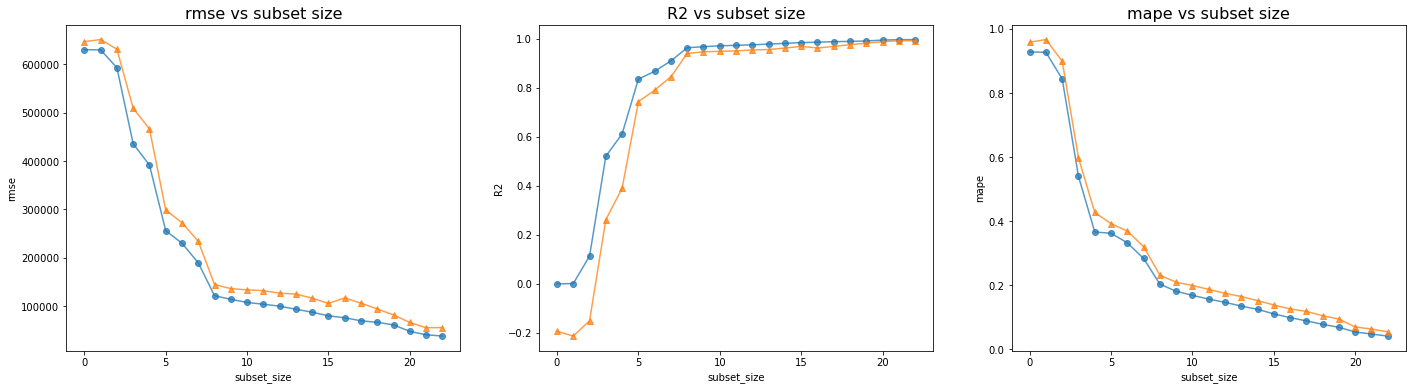

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
axs = axs.flat

train_ls = ["avg_train_rmse", "avg_train_R2", "avg_train_mape"]
test_ls = ["avg_test_rmse", "avg_test_R2", "avg_test_mape"]

for i in range(len(train_ls)):

    axs[i].plot(
        best_k_summary["subset_size"],
        best_k_summary[train_ls[i]],
        marker="o",
        alpha=0.75,
    )

    axs[i].plot(
        best_k_summary["subset_size"],
        best_k_summary[test_ls[i]],
        marker="^",
        alpha=0.75,
    )

    axs[i].set_xlabel("subset_size")
    axs[i].set_ylabel(train_ls[i].split("_")[-1])
    axs[i].set_title(f'{train_ls[i].split("_")[-1]} vs subset size', fontsize=16)

plt.show()

In [ ]:
### Ridge, lasso, elasticnet !!!!!!!!!!!!!!!!!!!